# Step-by-step MRI reconstruction using learned dictionaries

Jon Tamir <<jtamir@utexas.edu>>  
July 2020

## Introduction <a name="introduction"></a>

This code accompanies the educational talk given in the 2020 ISMRM Virtual Meeting:  

Hands-On: Image Reconstruction  
https://www.ismrm.org/20/program_files/STh08.htm

A live Q&A is planned on Thursday, 13 August 2020, 15:50 - 16:35 UTC. Change to local time-zone here:  
https://www.timeanddate.com/worldclock/converter.html?iso=20200813T155000&p1=1440&p2=195&p3=240&p4=24

---
The purpose of this code is to introduce and demonstrate dictionary learning for MRI. Users will be able to replicate some of the results in the ISMRM presentation, as well as change the various parameters and see their effect.

The code uses [SigPy](https://sigpy.readthedocs.io/en/latest/) developed by by Frank Ong et al. However, not all the demo code supports running on GPU, and was not implemented with  fast, vectorized code. Therefore, there is room to greatly reduce the run-time of these algorithms.

If you are running the demo in MyBinder, the fully-sampled image dictionary learning may take upwards of 45 minutes to run. This is because the free machines are very limited. On a local four-core CPU machine, it will take about 1 minute, and the final demo will take about 10 minutes.

# Table of contents
1. [Introduction](#introduction)
1. [Formulation](#formulation)
    1. [Orthogonal Matching Pursuit](#omp)
    1. [Sparse Decomposition](#sd)
    1. [Dictionary Learning](#dl)
1. [Sparse decomposition of synthetic data](#dlsynth)
1. [Dictionary learning for signal relaxation curves](#dlsig)
1. [Dictionary learning of image patches](#dlpatch)
1. [ Under-sampled dictionary learning MRI reconstruction](#dlmri)


---

Package imports. Of note, we will use `sigpy` to implement dictionary learning routines and `sigpy.plot` to display multi-dimensional images. We use `epgcpmg` to simulate CPMG echo trains using the Extended Phase Graph Algorithm. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from multiprocessing import Pool
import h5py

import sigpy as sp
import sigpy.plot as pl

import sys
sys.path.insert(1, './mri-sim-py/epg')
import epgcpmg as epg

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib notebook


Set some machine parameters

In [2]:
n_proc = 4 # number of cpu cores to use, when possible
figsize = (8, 4) # default figure size
device = sp.cpu_device # which device to use (not all is supported on GPU)

## Formulation <a name="formulation"></a>

In dictionary learning, our training set $\mathbf X \in \mathbb{C}^{N \times L}$ ($L$ training examples, each of length-$N$) is represented as a sparse linear combination of atoms from a dictionary $\mathbf D \in \mathbb{C}^{N \times K}$ with sparse codes $\mathbf A \in \mathbb{C}^{K\times L}$:
$$ \mathbf X = \mathbf D \mathbf A $$ 
where each column of $\mathbf D$ is a dictionary atom, and each column of $\mathbf A$ is a sparse code for the corresponding column in $\mathbf X$.

It is common to enforce a bounded l2-norm on the dictionary atoms to avoid scaling ambiguities. To enforce sparisty, we will explore two approaches:
1. Orthogonal Matching Pursuit, a greedy method for building a $K$-sparse vector to approximately solve
\begin{align}
\min_{\mathbf{A},\mathbf{D}} \frac{1}{2}||\mathbf{X} - \mathbf{DA} ||_2^2 \quad \text{subject to }& \\
||\alpha_l|| &\leq K, \quad l=1,...,L \\
||d_p|| & \leq 1, \quad p=1,...,P
\end{align}
1. Basis Pursuit, an l1-relaxation method for promoting sparsity:
\begin{align*}
\min_{\mathbf{A},\mathbf{D}} \frac{1}{2}||\mathbf{X} - \mathbf{DA} ||_2^2 + \lambda || \mathbf A || _1 \quad  \text{subject to }& 
||d_p|| \leq 1, \quad p=1,...,P
\end{align*}

In both cases, we can use alternating minimization to jointly solve for $\mathbf A$ and $\mathbf D$.

### Orthogonal Matching Pursuit <a name="omp"></a>
Our Orthogonal Matching Pursuit (OMP) algorithm is based on the folllowing paper:

TT Cai and L Wang, Orthogonal Matching Pursuit for Sparse Signal Recovery With Noise, IEEE Trans Info Theory, 57:7,  2011.  
http://math.mit.edu/~liewang/OMP.pdf

It approximately solves (1) above by successively building a vector until it has $K$ non-zeros. 

In [3]:
def omp_single(yi, D, num_nonzero_coeffs=3, use_sigpy=False, device=None):
    r"""Orthogonal Matching Pursuit (OMP) for a data point.
    Args:
        yi: [N, 1] data point
        D: [N, P] dictionary
        num_nonzero_coeffs: K in notation above
        device: SigPy device (cpu or gpu)
    Notes:
        Not fully tested on GPU
        Not vectorized for speed
    """
    
    device = sp.get_device(yi)
    xp = sp.Device(device).xp
    
    # initialize residual to y
    resid = yi
    idxs = []
    for k in range(num_nonzero_coeffs):
        # find dictionary most correlated with residual
        z = abs(xp.conj(D.T).dot(resid))
        ii = int(xp.argmax(z))
        idxs = idxs + [ii]
        Dsub = D[:, idxs]
        # solve for coefficients
        if use_sigpy:
            A_D = sp.linop.MatMul([len(idxs),1], Lsub)
            vals = sp.app.LinearLeastSquares(A_D, yi, show_pbar=False).run().ravel()
        else:
            if device is None or device == sp.cpu_device:
                rcond = None
            else:
                rcond = -1
            vals = xp.linalg.lstsq(Dsub, yi, rcond=rcond)[0]
        # update residual
        resid = yi - Dsub.dot(vals)
    return idxs, vals.ravel()


class OMP(sp.alg.Alg):
    r"""Orthogonal Matching Pursuit (OMP) algorithm for a batch of data.
    Each iteration of the algorithm processes the next data point, for 
    a total of L iterations
    Args:
        y: [N, L] data
        D: [N, P] dictionary
        num_nonzero_coeffs: K in notation above
        DC: whether to include a DC dictionary element
    """

    def __init__(
            self,
            y,
            D,
            num_nonzero_coeffs,
            device=sp.cpu_device,
            DC=False,
            **kwargs):
        
        
        self.max_iter = y.shape[1]
            
        self.y = sp.to_device(y, device)
        self.D = sp.to_device(D, device)
        self.num_filters = self.D.shape[-1]
        self.num_nonzero_coeffs = num_nonzero_coeffs
        self.device = sp.Device(device)
        self.DC = DC
        
        self.dtype = self.y.dtype
        self.num_points, self.num_data = self.y.shape
        self.A_shape = (self.num_filters, self.num_data)

        xp = self.device.xp
        self.A = xp.zeros((self.num_filters, self.num_data), dtype=self.y.dtype)
        self.iter = 0
                
        super().__init__(self.max_iter)
        
    def _update(self):

        xp = self.device.xp
        yi = self.y[:, self.iter]
        idxs, vals = omp_single(yi, self.D, self.num_nonzero_coeffs, device=self.device)
        self.A[idxs, self.iter] = vals.ravel()
        
    def _done(self):
        return (self.iter >= self.max_iter)   
    
    

### Sparse Decomposition <a name="sd"></a>
In the sparse decomposition stage, the dictionary is fixed and we update the sparse code (coefficients) of each column of $A$. Our sparse code will support both OMP and L1-minimization.

In [4]:
class SparseDecom(sp.app.App):
    r"""Compute the sparse coefficients for a dataset given a fixed dictionary
    Args:
        y: [N, L] data
        D: [N, P] dictionary
        lamda: sparsity level (if mode='omp') or l1-regularization parameter (if mode='l1')
        mode: 'l1' for l1-regularization or 'omp' for OMP
        DC: whether to include a DC dictionary element
        device: CPU or GPU
    """      
    def __init__(
        self,
        y,
        D,
        lamda=0.005,
        mode='l1',
        DC=False,
        device=sp.cpu_device,
        show_pbar=True,
        leave_pbar=True,
        **kwargs):
        
        self.y = sp.to_device(y, device)
        self.D = sp.to_device(D, device)
        self.lamda = lamda
        self.device = device
        self.mode = mode
        self.show_pbar = show_pbar
        self.leave_pbar = leave_pbar

        self._get_params()
        
        if self.mode is 'omp':
            self.alg = OMP(self.y, 
                           self.D, 
                           self.lamda, 
                           DC=DC,
                           device=self.device)
        elif self.mode is 'l1':
            self.A = sp.linop.MatMul(
                self.A_shape,
                self.D)
            
            proxg_A = sp.prox.L1Reg(self.A_shape, lamda)

            self.alg = sp.app.LinearLeastSquares(self.A, 
                                                 self.y, 
                                                 proxg=proxg_A, 
                                                 show_pbar=self.show_pbar, 
                                                 **kwargs).alg
         
        
        super().__init__(self.alg, show_pbar=self.show_pbar, leave_pbar=self.leave_pbar)
        
        self._output = self.__output


    def _get_params(self):
        self.device = sp.Device(self.device)
        self.dtype = self.y.dtype
        self.num_data = self.y.shape[-1]
        self.num_filters = self.D.shape[-1]
        self.num_points = self.D.shape[0]

        self.A_shape = (self.num_filters, self.num_data)
        
    def __output(self):
        if self.mode == 'omp':
            return self.alg.A
        else:
            return self.alg.x


def nrmse(x, y):
    r"""Calculate normalized root mean-squared error:
    || x - y||_2 / ||x||_2
    """
    xp = sp.get_device(x).xp
    return xp.linalg.norm(x.ravel() - y.ravel()) / xp.linalg.norm(x.ravel())


### Dictionary Learning and the K-SVD Algorithm <a name="dl"></a>
Our Dictionary Learning algorithm will alternate between updating the dictionary and updating the sparse codes. For the dictionary update, we will support two different methods:
1. A global linear least-squares with l2-regularization of previous estimate
1. The K-SVD algorithm. The K-SVD algorithm is an approach for sequentially updating each dictionary atom, and has been shown to outperform linear least squares:
1. The approximate K-SVD. This is a variant of K-SVD that is faster.

K-SVD: M Aharon, M Elad, AM Bruckstein, The K-SVD: An algorithm for designing of
overcomplete dictionaries for sparse representation, IEEE Trans. Signal Process., vol.
54, no. 11, pp. 4311-4322, 2006.  
https://ieeexplore.ieee.org/document/1710377

Approximate K-SVD:
http://www.cs.technion.ac.il/~ronrubin/Publications/KSVD-OMP-v2.pdf

The Dictionary Learning app supports running the update across a random batch of training data each outer iteration

In [5]:
class DictionaryLearning(sp.app.App):
    r"""Dictionary Learning. Solves the optimization problem \min_{A, D} || X - AD ||_2^2 + R1(A) + R2(D),
    where R2(D) enforces l2-norm of each column of D, and R1(A) enforces sparsity of A.
    R1(A) supports either OMP or L1-minimization.
    To update D, supports either linear least-squares, K-SVD, or approximate K-SVD
    
    Args:
        y: [N, L] data
        num_filters: number of dictionary atoms
        batch_size: batch size for each alternating minimization outer loop
        lamda: sparsity level (if A_mode='omp') or l1-regularization parameter (if A_mode='l1')
        alpha: l2-regularization for dictionary update (if L_mode='lls')
        A_mode: How to update sparse codes.
            'l1' for l1-regulaization or 'omp' for OMP
        D_mode: How to update dictionary. 
            'lls' for linear least squares,'ksvd' for K-SVD, or 'aksvd' for approximate K-SVD
        D_init_mode: How to initialize the dictionary.
            'random' for random, 'svd' for singular value decomposition, 'data' for using the data itself
        DC: whether to include a DC dictionary element
        skip_final_decomp: True to not run the final SparseDecomposition on the full data
        max_inner_iter: How many inner iterations (for A_mode='l1' and D_mode='lls')
        max_power_iter: How many power iterations (for A_mode='l1' and D_mode='lls')
        max_iter: How many alternating minimization outer iterations
        device: CPU or GPU
    """         
    
    def __init__(
            self,
            y,
            num_filters,
            batch_size,
            lamda=0.001,
            alpha=0.5,
            A_mode='omp',
            D_mode='ksvd',
            mask_idx=None,
            D_init_mode='random',
            DC=False,
            skip_final_decomp=False,
            max_inner_iter=100,
            max_power_iter=10,
            max_iter=10,
            device=sp.cpu_device,
            **kwargs):
        self.y = sp.to_device(y, device) 
        self.num_filters = num_filters
        self.batch_size = batch_size
        self.lamda = lamda
        self.alpha = alpha
        self.A_mode = A_mode
        self.D_mode = D_mode
        self.max_inner_iter = max_inner_iter
        self.max_power_iter = max_power_iter
        self.max_iter = max_iter
        self.device = device
        self.D_init_mode = D_init_mode
        self.DC = DC
        self.skip_final_decomp = skip_final_decomp
        self.mask_idx = mask_idx
        self.current_resid = []

        self._get_params()
        self._get_vars()
        self._get_alg()

        super().__init__(self.alg, show_pbar=True, **kwargs)


    def _get_params(self):
        self.device = sp.Device(self.device)
        self.dtype = self.y.dtype
        self.num_points, self.num_data = self.y.shape
        self.batch_size = min(self.num_data, self.batch_size)
        self.num_batches = self.num_data // self.batch_size
        self.t_start = 0
        self.batch_ridx = np.random.permutation(self.num_data)
        
        self.D_shape = (self.num_points, self.num_filters)
        self.A_t_shape = (self.num_filters, self.batch_size)
           
    def _get_vars(self):
        xp = self.device.xp
        with self.device:
            # storage for batch size amount of data
            self.y_t = xp.empty((self.num_points, self.batch_size),
                                dtype=self.dtype)
            
            # Dictionary initialization
            if self.D_init_mode == 'random':
                self.D = sp.randn(self.D_shape, dtype=self.dtype,
                  device=self.device)
            elif self.D_init_mode == 'svd':
                uu, ss, vv = xp.linalg.svd(self.y, full_matrices=False)
                self.D = vv[:, :self.num_filters]
            elif self.D_init_mode == 'data':
                ridx = np.random.permutation(self.num_data)
                self.D = self.y[:, ridx[:self.num_filters]]
            else:
                self.D = sp.to_device(self.D_init_mode, self.device)
                
            # Normalize each dictionary atom    
            if self.DC:
                self.D -= xp.mean(self.D, axis=0, keepdims=True)
                self.D[:, 0] = 1

            self.D /= xp.sum(xp.abs(self.D)**2,
                             axis=(0),
                             keepdims=True)**0.5
            
            self.D_old = xp.empty(self.D_shape, dtype=self.dtype)

            self.A = xp.zeros((self.num_filters, self.num_data), dtype=self.dtype)
            self.A_t = xp.zeros((self.num_filters, self.batch_size), dtype=self.dtype)
            
    def _get_alg(self):
        
        def min_A_t():
            self.A_t = SparseDecom(
                self.y_t,
                self.D,
                lamda=self.lamda,
                mode=self.A_mode,
                DC=self.DC,
                max_power_iter=self.max_power_iter,
                max_iter=self.max_inner_iter,
                device=self.device,
                show_pbar=False).run()

        def min_D_lls():
            assert not self.DC, 'not implemented'

            self.Aop_D = sp.linop.RightMatMul(
                self.D_shape,
                self.A_t)

            mu = (1 - self.alpha) / self.alpha

            proxg_D = sp.prox.L2Proj(
                self.D.shape, 1., axes=[0])

            sp.app.LinearLeastSquares(self.Aop_D, self.y_t, x=self.D,
                                      z=self.D_old,
                                      proxg=proxg_D,
                                      lamda=mu,
                                      max_power_iter=self.max_power_iter,
                                      max_iter=self.max_inner_iter, show_pbar=False).run()
               
        def min_D_ksvd():
            if self.D_mode == 'ksvd':
                approx = False
            else:
                approx = True
            for k in np.random.permutation(self.num_filters):
                if k > 0 or (not self.DC):
                    self.ksvd(k, approx=approx)
                
        if self.D_mode == 'lls':
            min_D = min_D_lls
        else:
            min_D = min_D_ksvd
            
        self.alg = sp.alg.AltMin(min_A_t, min_D, max_iter=self.max_iter)

    def ksvd(self, k, approx=False):
        r""" K-SVD algorithm.
        Supports either full K-SVD, or approximate K-SVD.
        """
        xp = self.device.xp
        lk = self.D[:, k][:,None]
        ak = self.A_t[k, :][None,:]
        idx = ak.ravel() != 0
        if np.sum(idx) > 0:
            if approx:
                self.D[:, k] = 0
                g = ak[:, idx].T
                yI = self.y_t[:, idx]
                AI = self.A_t[:, idx]
                d = yI.dot(g) - self.D.dot(AI).dot(g)
                d /= xp.linalg.norm(d)
                g = yI.T.dot(d) - xp.conj(self.D.dot(AI)).T.dot(d)
                self.D[:, k] = d.ravel()
                self.A_t[k, idx] = g.T
            else:
                Ek = self.y_t - self.D.dot(self.A_t) + lk.dot(ak)
                EkR = Ek[:, idx]
                uu, ss, vv = xp.linalg.svd(EkR, full_matrices=False)
                self.D[:, k] = uu[:,0]
                self.A_t[k, idx] = vv[0,:] * ss[0]          
    
    def _pre_update(self):
        
        ridx_t = self.batch_ridx[self.t_start:self.t_start+self.batch_size]
        
        self.t_start = self.t_start + self.batch_size
        
        if self.t_start >= self.num_data:
#             print('reset ridx. t_start is', self.t_start, 'ridx_t is', ridx_t.shape)
            self.batch_ridx = np.random.permutation(self.num_data)
            
            if len(ridx_t) < self.batch_size:
                self.t_start = self.batch_size - len(ridx_t)
                ridx_t = np.concatenate((ridx_t, self.batch_ridx[:self.t_start]))
            else:
                self.t_start = 0

        sp.copyto(self.y_t, self.y[:,ridx_t])
        sp.copyto(self.D_old, self.D)
    
    def _summarize(self):
        if self.show_pbar:
            xp = self.device.xp
            self.current_resid.append(sp.to_device(xp.linalg.norm(self.y_t - self.D.dot(self.A_t)), sp.cpu_device))
            self.pbar.set_postfix(resid='{0:.2E}'.format(self.current_resid[-1]))

    def _output(self):  
        if not self.skip_final_decomp:
            self.A = SparseDecom(
                self.y,
                self.D,
                lamda=self.lamda,
                mode=self.A_mode,
                max_power_iter=self.max_power_iter,
                max_iter=self.max_inner_iter,
                device=self.device,
                show_pbar=True,
                leave_pbar=False).run()
        return self.D, self.A



## Denoise synthetic data <a name="dlsynth"></a>
We create synthetic data that fits the model with a random dictionary and K-sparse vectors. We add noise and estimate the sparse codes using OMP and L1-minimization

(50, 500) (50, 100) (100, 500)


<IPython.core.display.Javascript object>


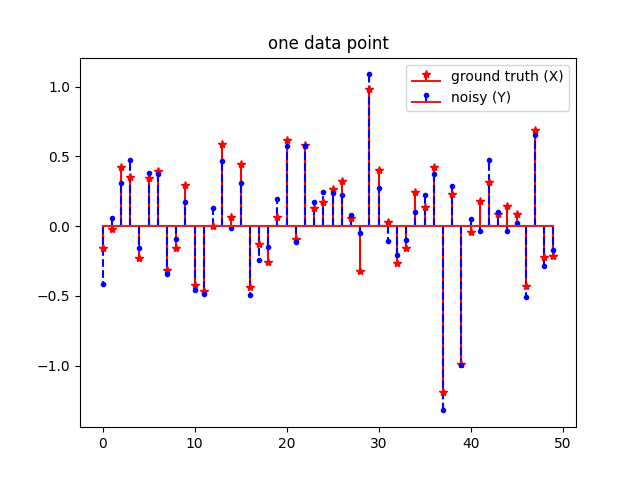

In [36]:
num_data = 500 # L above
num_points = 50 # N above
num_filters = 100 # P above
num_nonzero_coeffs = 5 # K above
l1_lamda = .1 # lambda above


A = np.vstack((np.random.randn(num_nonzero_coeffs, num_data), np.zeros((num_filters - num_nonzero_coeffs, num_data)))).T
A = np.array([np.random.permutation(ai) for ai in A]).T
D = np.random.randn(num_points, num_filters)
D = D / np.linalg.norm(D, axis=0)[None,:]
X = D.dot(A)

stdev = 0.1

Y = X + stdev * np.random.randn(*X.shape)

print(X.shape, D.shape, A.shape)
plt.figure()
plt.stem(X[:,:1], markerfmt='r*', linefmt='r', use_line_collection=True);
plt.stem(Y[:,:1], markerfmt='b.', linefmt='b--', use_line_collection=True);
plt.title('one data point')
plt.legend(('ground truth (X)', 'noisy (Y)'))

In [37]:
with device:
    print('OMP')
    app = SparseDecom(Y, D, num_nonzero_coeffs, mode='omp', max_iter=100, device=device)
    A_hat_omp = app.run()

    print('L1')
    app = SparseDecom(Y, D, l1_lamda, mode='l1', max_iter=100, device=device)
    A_hat_l1 = app.run()
    
A_hat_omp = sp.to_device(A_hat_omp, sp.cpu_device)   
A_hat_l1 = sp.to_device(A_hat_l1, sp.cpu_device)

X_hat_omp = D.dot(A_hat_omp)
X_hat_l1 = D.dot(A_hat_l1)

print('NRMSE between noisy and true data:', nrmse(X, Y))
print('NRMSE between OMP estimate and true data:', nrmse(X, X_hat_omp))

print('NRMSE between L1 estimate and true data:', nrmse(X, X_hat_l1))

OMP



L1



NRMSE between noisy and true data: 0.3238496576942619
NRMSE between OMP estimate and true data: 0.1736580818575804
NRMSE between L1 estimate and true data: 0.1960366092177552


<IPython.core.display.Javascript object>


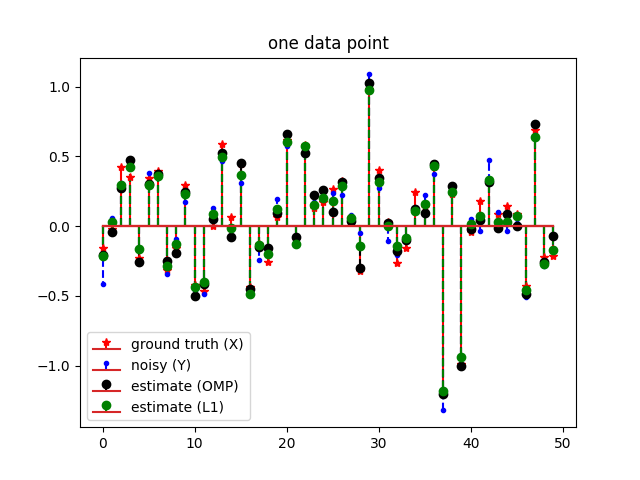

Text(0.5, 1.0, 'one data point')

In [38]:
plt.figure()
plt.stem(X[:,:1], markerfmt='r*', linefmt='r', use_line_collection=True);
plt.stem(Y[:,:1], markerfmt='b.', linefmt='b--', use_line_collection=True);
plt.stem(X_hat_omp[:,:1], markerfmt='ko', linefmt='k--', use_line_collection=True);
plt.stem(X_hat_l1[:,:1], markerfmt='go', linefmt='g--', use_line_collection=True);

plt.legend(('ground truth (X)', 'noisy (Y)', 'estimate (OMP)', 'estimate (L1)'))
plt.title('one data point')



## Dictionary learning for signal relaxation curves <a name="dlsig"></a>
We will simulate a family of variable flip-angle multi-echo spin-echo curves and approximate it with dictionary learning.

### Load and simulate data
First we load relaxation values from a brain imaging experiment at 3T, as well as variable refocusing flip angle array.

<IPython.core.display.Javascript object>


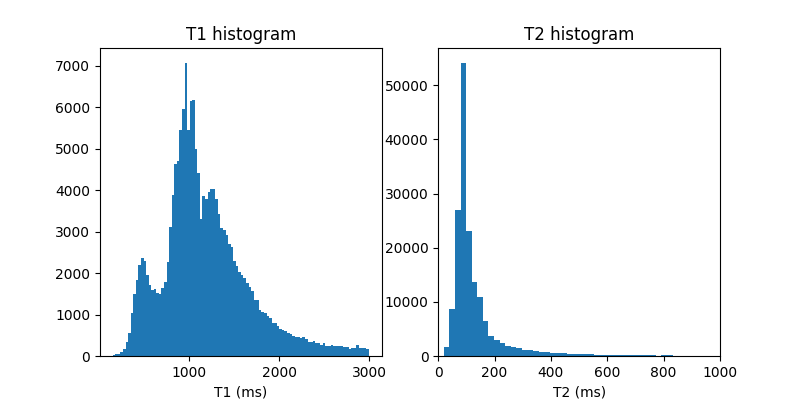

<IPython.core.display.Javascript object>


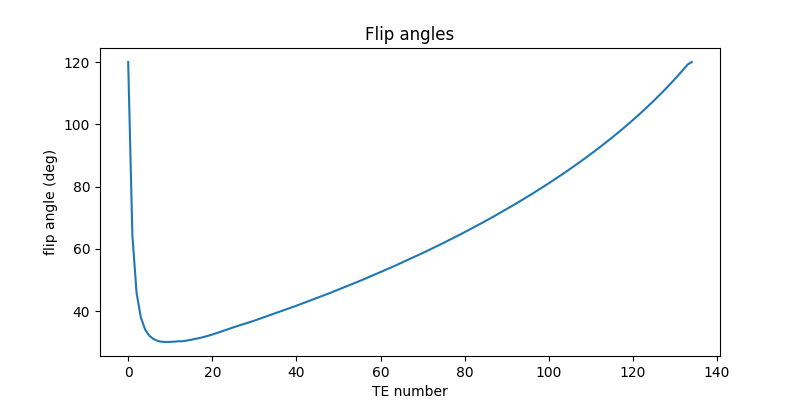

In [9]:
t1_t2_brain = np.load('data/t1t2_brain.npy')
flipangles = np.loadtxt('data/flipangles.txt')
flipangles_rad = flipangles * np.pi / 180
T = len(flipangles)
N_total = t1_t2_brain.shape[0]

plt.figure(figsize=figsize)
plt.subplot(1,2,1)
plt.hist(t1_t2_brain[:,0], 100)
plt.title('T1 histogram')
plt.xlabel('T1 (ms)')

plt.subplot(1,2,2)
plt.hist(t1_t2_brain[:,1], 100)
plt.title('T2 histogram')
plt.xlabel('T2 (ms)')
plt.xlim([0, 1000])

plt.figure(figsize=figsize)
plt.plot(flipangles)
plt.title('Flip angles')
plt.xlabel('TE number')
plt.ylabel('flip angle (deg)');




In [10]:
TR = 2500 # repetition time in ms
TE = 5 # echo time in ms
num_data = 1000 # number of training data points

_ridx = np.random.permutation(N_total)
t1_t2_vals = t1_t2_brain[_ridx[:num_data], :]

n_proc = 20 # number of cpu cores to use, when possible


def _gen_signal(t1_t2):
    t1, t2 = t1_t2
    return epg.FSE_signal(flipangles_rad, TE, t1, t2).squeeze()

with Pool(n_proc) as p:
    sig_mat = list((tqdm(p.imap(_gen_signal, t1_t2_vals), total=num_data, leave=True)))

sig_mat = np.array(sig_mat)
print(sig_mat.shape)


(1000, 135)


Next we simulate the sequence with the EPG algorithm

<IPython.core.display.Javascript object>


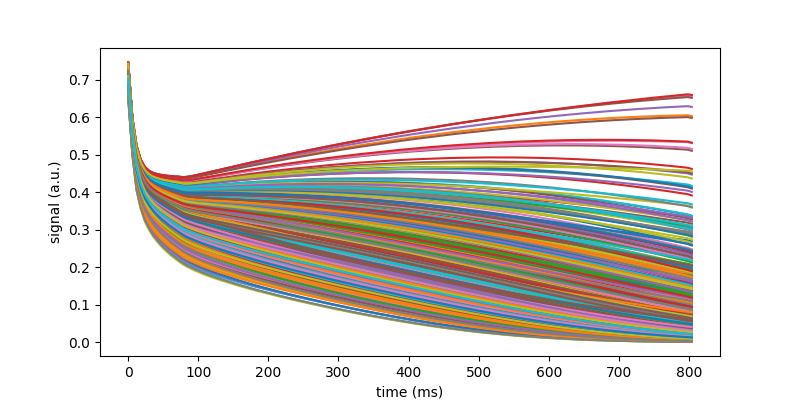

In [11]:
figsize = (8, 4) # default figure size

plt.figure(figsize=figsize)
plt.plot(np.arange(T)*(1+TE), sig_mat.T);
# plt.title('Signal relaxation curves')
plt.xlabel('time (ms)')
plt.ylabel('signal (a.u.)');

### Approximate with Principal Component Analysis <a name="pca"></a>
With principal component analysis (PCA) without mean-centering, we are able to represent each length-135 curve with approximately 3 coefficients:


<IPython.core.display.Javascript object>


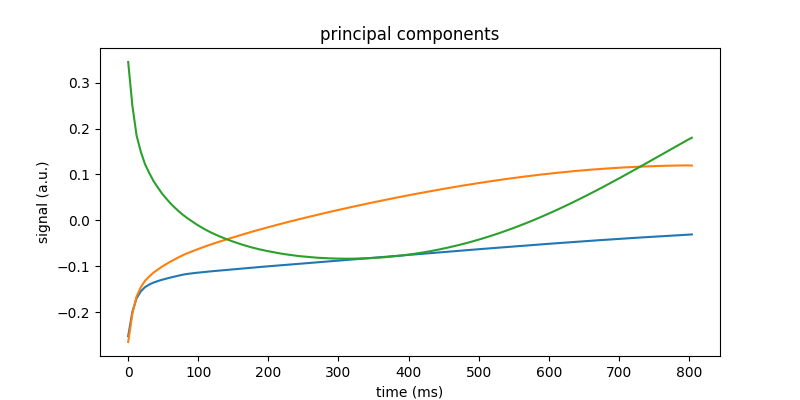

(135, 1000)
Subspace error: 0.006254562465121853


<IPython.core.display.Javascript object>


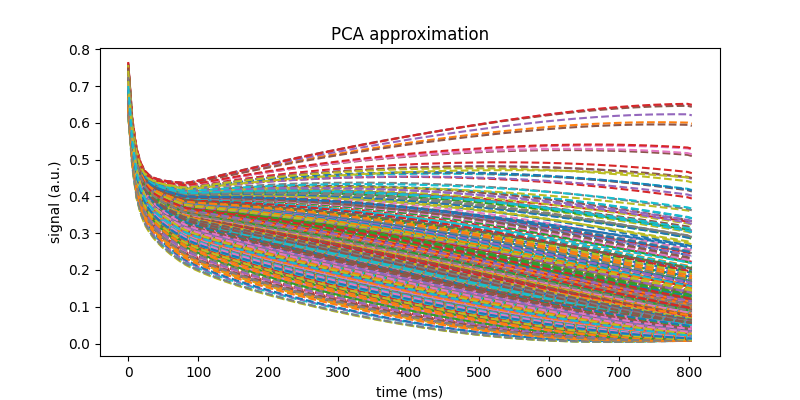

In [12]:
K = 3
u, s, v = np.linalg.svd(sig_mat, full_matrices=False)
phi = v[:K,:]


plt.figure(figsize=figsize)
plt.plot(np.arange(T)*(1+TE), phi.T);
plt.title('principal components')
plt.xlabel('time (ms)')
plt.ylabel('signal (a.u.)');

y_hat_basis = np.conj(phi).T.dot(phi.dot(sig_mat.T))
print(y_hat_basis.shape)
print('Subspace error:', nrmse(sig_mat.T, y_hat_basis))
      
plt.figure(figsize=figsize)
plt.plot(np.arange(T)*(1+TE), y_hat_basis, '--');
plt.title('PCA approximation')
plt.xlabel('time (ms)')
plt.ylabel('signal (a.u.)');

### Approximate with Dictionary Learning <a name="dlsynth2"></a>
We will run Dictionary Learning using OMP and K-SVD, and fit the curves to two coefficients with 20 filters.
Notice that in this case, we are **not** using an over-complete dictionary. This is because the data really does lie in a subspace, and does not require a union of subspaces. Thus, although dictionary learning is overkill for this situation, it can still be used to further sparsify the representation.

We will initialize the dictionary with curves directly from the data, as well as include a DC-atom, as suggested by the K-SVD paper.

In [34]:
num_filters = 20
num_nonzero_coeffs = 2

y = sig_mat.T

with device:
    app = DictionaryLearning(y,
                       num_filters,
                       D_init_mode='data', 
                       batch_size=100,
                       A_mode='omp',
                       D_mode='ksvd',
                       lamda=num_nonzero_coeffs, 
                       DC=True,
                       alpha=0.5,
                       max_iter=200,
                      leave_pbar=True)
    out = app.run()

D_hat, A_hat = out[0], out[1]
y_hat = D_hat.dot(A_hat)
print(D_hat.shape, A_hat.shape, y_hat.shape)
print(y_hat.shape)
print('Dictionary Learning error:', nrmse(y, y_hat))


(135, 20) (20, 1000) (135, 1000)
(135, 1000)
Dictionary Learning error: 0.007488725500618461


<IPython.core.display.Javascript object>


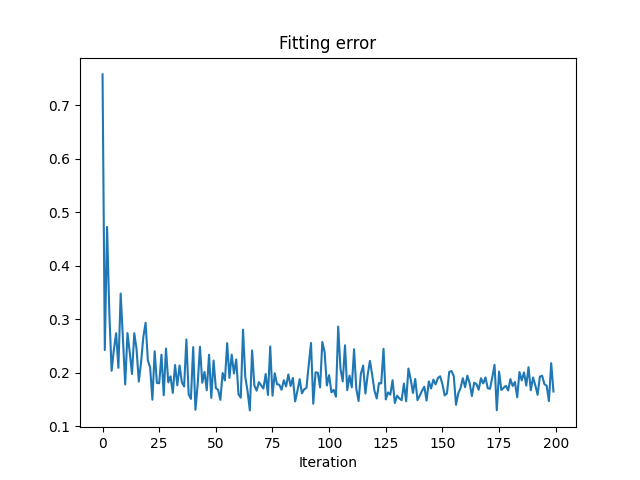

<IPython.core.display.Javascript object>


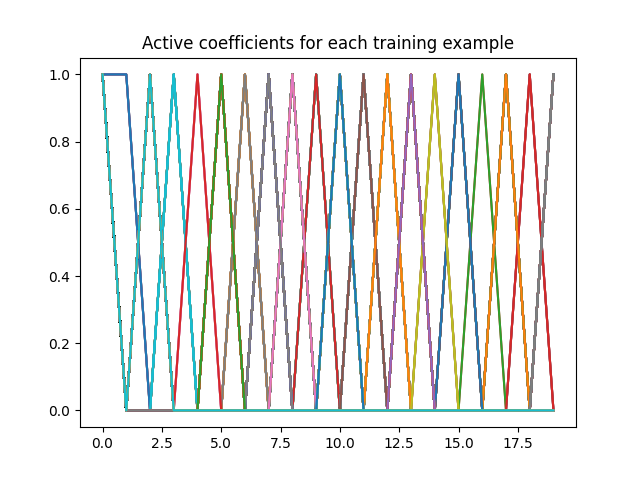

<IPython.core.display.Javascript object>


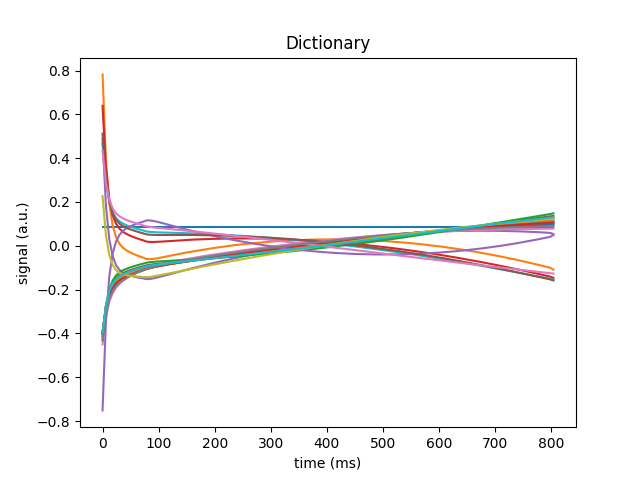

<IPython.core.display.Javascript object>


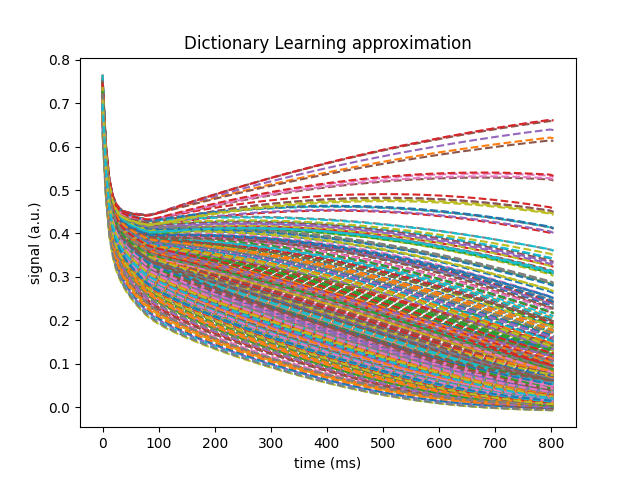

In [35]:
plt.figure()
plt.plot(app.current_resid)
plt.xlabel('Iteration')
plt.title('Fitting error')


plt.figure()
plt.plot(A_hat != 0);
plt.title('Active coefficients for each training example')

plt.figure()
plt.plot(np.arange(T)*(1+TE), D_hat)
plt.title('Dictionary')
plt.xlabel('time (ms)')
plt.ylabel('signal (a.u.)');

plt.figure()
plt.plot(np.arange(T)*(1+TE), y_hat, '--');
plt.title('Dictionary Learning approximation')
plt.xlabel('time (ms)')
plt.ylabel('signal (a.u.)');

### Compare PCA to Dictionary Learning for a few examples

<IPython.core.display.Javascript object>


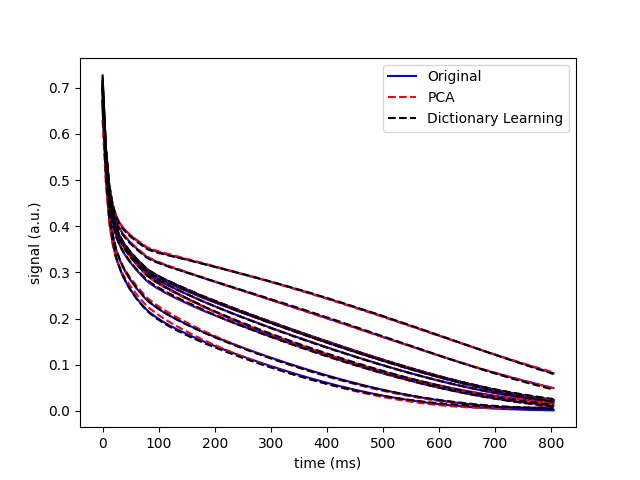

In [15]:
_ridx = np.random.permutation(num_data)
_N = 10

plt.figure()
# for legend
plt.plot(np.arange(T)*(1+TE), y[:,_ridx[0]], 'b-');
plt.plot(np.arange(T)*(1+TE), y_hat_basis[:,_ridx[0]], 'r--');
plt.plot(np.arange(T)*(1+TE), y_hat[:,_ridx[0]], 'k--');

plt.plot(np.arange(T)*(1+TE), y[:,_ridx[1:_N]], 'b-');
plt.plot(np.arange(T)*(1+TE), y_hat_basis[:,_ridx[1:_N]], 'r--');
plt.plot(np.arange(T)*(1+TE), y_hat[:,_ridx[1:_N]], 'k--');
plt.legend(('Original', 'PCA', 'Dictionary Learning'))

plt.xlabel('time (ms)')
plt.ylabel('signal (a.u.)');

## Dictionary learning of patches from fully-sampled MR image <a name="dlpatch"></a>
We will approximate patches from an MR image using dictionary learning, where each patch is represented as a sparse linear combination of dictionary atoms (patches). We will use OMP and K-SVD for this part.

First we load the data from a brain MRI scan. The data was downloaded from the [fastmri.org](http://fastmri.org) The file corresponds to the following:

Validation data, `file_brain_AXFLAIR_200_6002462.h5`, slice 4

In [16]:
with h5py.File('data/brain.h5', 'r') as F:
    ksp = np.array(F['kspace'])
    img = np.array(F['image'])
    mask = np.array(F['mask'])
    maps = np.array(F['maps'])

<IPython.core.display.Javascript object>


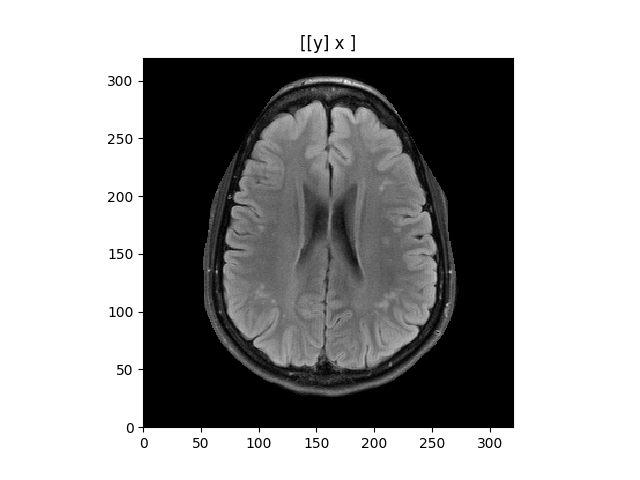

In [17]:
pl.ImagePlot(img);

### Run Dictionary Learning
We will extract overlapping patches for training data. We will specify an overcomplete dictionary. We will include a DC-only atom.

This takes about ~1 minute on a 4-core laptop

In [18]:
block_shape = [8, 8]
block_strides = [4, 4]
   
num_filters = 141
num_nonzero_coeffs = 15

DC = True
max_iter = 35


img_blocks = sp.array_to_blocks(img, block_shape, block_strides)
print(img_blocks.shape)

y_img_blocks = img_blocks.reshape((-1, np.prod(block_shape))).T
print(y_img_blocks.shape)

# remove patches with little-to-no signal
_nrms = np.linalg.norm(y_img_blocks, axis=0)
_mean_nrms = np.mean(_nrms)
print(_mean_nrms)

y_img_blocks_pruned = y_img_blocks[:, _nrms > .25 * _mean_nrms]
print(y_img_blocks.shape, y_img_blocks_pruned.shape)


with device:
    app = DictionaryLearning(y_img_blocks_pruned, 
                       num_filters, 
                       batch_size=500, 
                       A_mode='omp', 
                       D_mode='ksvd', 
                       D_init_mode='random',
                       DC=DC,
                       lamda=num_nonzero_coeffs,
                       alpha=0.5,
                       max_iter=max_iter, 
                       skip_final_decomp=True,
                       device=device)
    out = app.run()
    
    app2 = SparseDecom(y_img_blocks,
                       out[0],
                       num_nonzero_coeffs, 
                       mode='omp', 
                       DC=DC,
                       max_iter=100, 
                       device=device)
    out2 = app2.run()


(79, 79, 8, 8)
(64, 6241)
0.0004640382
(64, 6241) (64, 3113)


<IPython.core.display.Javascript object>


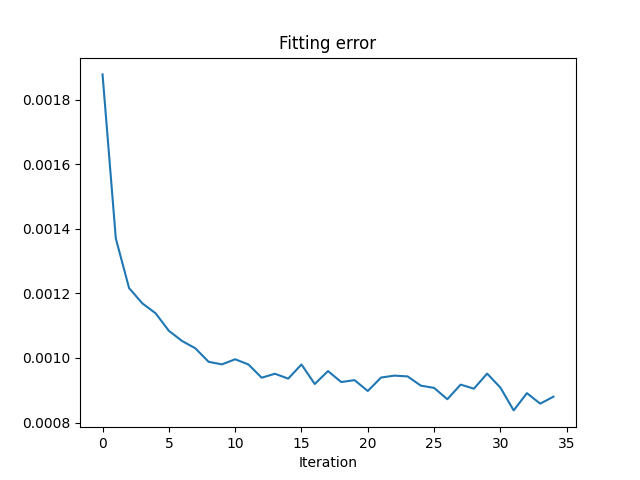

In [19]:
plt.figure()
plt.plot(app.current_resid)
plt.title('Fitting error')
plt.xlabel('Iteration');

Visualize the dictionary as complex-valued patches. Use the arrow keys, "z", "m", "p", "r", "i", to interact with the figure. Use "h" to show help.
Notice the first atom is DC

(8, 8, 141) (141, 79, 79)


<IPython.core.display.Javascript object>


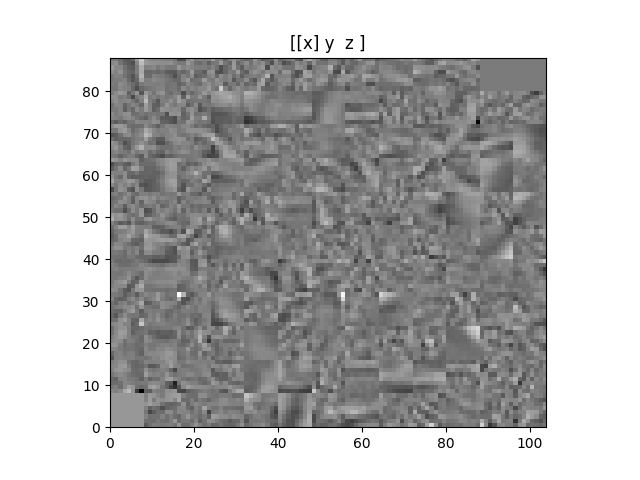

In [20]:
D_hat_flat, A_hat_flat = sp.to_device(out[0], sp.cpu_device), sp.to_device(out2, sp.cpu_device)
D_hat = D_hat_flat.reshape((*block_shape, num_filters))
A_hat = A_hat_flat.reshape((num_filters, *img_blocks.shape[:-2]))

print(D_hat.shape, A_hat.shape)

pl.ImagePlot(D_hat, x=-3, y=-2, z=-1, interpolation='nearest', mode='r')

Visualize some of the sparse coefficients. By construction, every patch will include a sparse coefficient weighting on the first atom (since it is the DC atom). Patches with similar image content will activate similar coefficients.

<IPython.core.display.Javascript object>


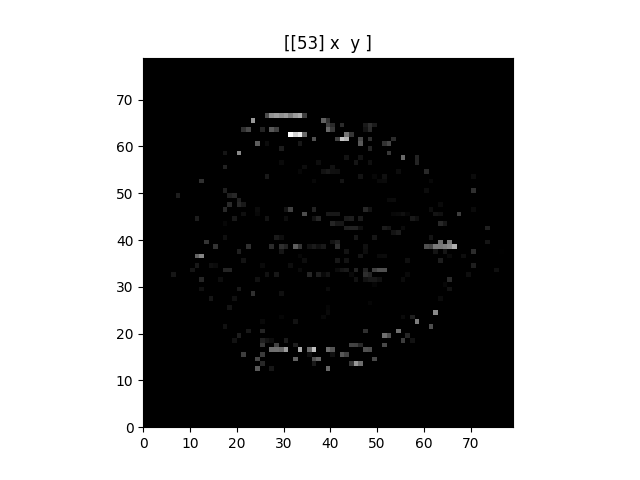

In [21]:
pl.ImagePlot(A_hat, x=-2, y=-1)

Approximate each patch using the dictionary and sparse codes, and reshape/average patches back to an image. The plot compares the original image, dictionary learning approximation, and difference image. Use the up/down arrow keys to switch between the three images in the plot

(64, 6241)


<IPython.core.display.Javascript object>


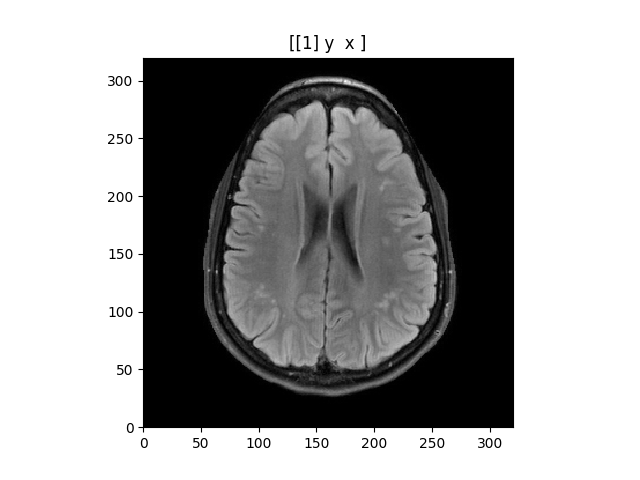

In [22]:
img_hat_flat = D_hat_flat.dot(A_hat_flat)
print(img_hat_flat.shape)

img_hat_blocks = img_hat_flat.T.reshape(img_blocks.shape)
img_hat = sp.blocks_to_array(img_hat_blocks, img.shape, block_shape, block_strides)
img2 = sp.blocks_to_array(img_blocks, img.shape, block_shape, block_strides)

pl.ImagePlot(np.stack((img2, img_hat, img2-img_hat)))


## Under-sampled Dictionary Learning MRI <a name="dlmri"></a>
We will now perform under-sampled MRI reconstruction using the dictionary learning model for regularization. The dictionary will be initialized using the zero-filled k-space, and subsequently learned directly from the under-sampled data in an iterative optimization.

## Formulation <a name="formulation"></a>
The objective function is given by

\begin{align}
\min_{\mathbf{x}, \mathbf{A},\mathbf{D}} \frac{1}{2}||\mathbf y - \mathbf{Ex} ||_2^2 + \frac{\nu}{2} || \mathbf x - \mathbf{R(DA)}||_2^2\quad \text{subject to }& \\
||\alpha_l|| &\leq K, \quad l=1,...,L \\
||d_p|| & \leq 1, \quad p=1,...,P
\end{align}

where $\mathbf E$ is the MRI encoding operator, $\mathbf{R(\mathbf X)}$ reshapes image patches into an image, and $\nu$ is a regularization parameter.

To approximately solve this objective function, we use alternating minimization between $\mathbf x$ and $(\mathbf D, \mathbf A)$. 

Reference:  
S Ravishankar, Y Bresler, MR Image Reconstruction From Highly Undersampled k- Space Data by Dictionary Learning, IEEE Transactions on Medical Imaging, vol. 30, no.5, pp. 1028-1041, May 2011.

In [23]:
from sigpy.mri.linop import Sense

class DictionaryLearningMRI(sp.app.App):
    r"""Dictionary Learning. Solves the optimization problem \min_{A, D} || X - AD ||_2^2 + R1(A) + R2(D),
    where R2(D) enforces l2-norm of each column of D, and R1(A) enforces sparsity of A.
    R1(A) supports either OMP or L1-minimization.
    To update D, supports either linear least-squares, K-SVD, or approximate K-SVD
    
    Args:
        ksp: [nc, nx, ny] of [nx, ny] kspace with optional multi-channel dimension
        mask: [nx, ny] Cartesian sampling pattern
        maps: [nc, nx, ny] sensitivity maps if multi-channel, None otherwise
        num_filters: number of dictionary atoms
        batch_size: batch size for each alternating minimization outer loop
        block_shape: image patch shape
        block_strides: image patch strides
        lamda: sparsity level (if A_mode='omp') or l1-regularization parameter (if A_mode='l1')
        alpha: l2-regularization for dictionary update (if L_mode='lls')
        nu: regularization parameter trading off data consistency vs. approximation error
        A_mode: How to update sparse codes.
            'l1' for l1-regulaization or 'omp' for OMP
        D_mode: How to update dictionary. 
            'lls' for linear least squares,'ksvd' for K-SVD, or 'aksvd' for approximate K-SVD
        D_init_mode: How to initialize the dictionary.
            'random' for random, 'svd' for singular value decomposition, 'data' for using the data itself
        DC: whether to include a DC dictionary element
        max_inner_iter: How many inner iterations (for A_mode='l1' and D_mode='lls')
        max_power_iter: How many power iterations (for A_mode='l1' and D_mode='lls')
        max_iter: How many alternating minimization outer iterations
        img_ref: optional ground-truth image to calculate NRMSE each iteration
        device: CPU or GPU
    """         
    def __init__(
            self,
            ksp, # [nc, nx, ny]
            mask, #[nx, ny]
            maps,
            num_filters,
            batch_size,
            block_shape, # [bx, by]
            block_strides, # [sx sy]
            lamda=0.001,
            alpha=0.5,
            nu = .01,
            A_mode='omp',
            D_mode='ksvd',
            D_init_mode='random',
            DC=False,
            max_inner_iter=100,
            max_power_iter=10,
            max_iter=10,
            img_ref=None,
            device=sp.cpu_device,
            **kwargs):
        
        
        self.ksp = sp.to_device(ksp, device)
        self.mask = sp.to_device(mask, device)
       
        self.maps = maps
        if self.maps != None:
            self.maps = sp.to_device(maps, device)
        
        if img_ref is None:
            self.img_ref = None
        else:
            self.img_ref = sp.to_device(img_ref, device)

        self.num_filters = num_filters
        self.batch_size = batch_size
        self.block_shape = block_shape
        self.block_strides = block_strides
        self.nu = nu
        self.lamda = lamda
        self.alpha = alpha
        self.A_mode = A_mode
        self.D_mode = D_mode
        self.max_inner_iter = max_inner_iter
        self.max_power_iter = max_power_iter
        self.max_iter = max_iter
        self.device = device
        self.D_init_mode = D_init_mode
        self.DC = DC

        self.first = True
        self.residuals = []
        self.nrmse_vals = []

        self._get_params()
        self._get_vars()
        self._get_alg()

        super().__init__(self.alg, **kwargs)
           
        
    def _get_params(self):
        self.device = sp.Device(self.device)
        self.dtype = self.ksp.dtype
        
        self.ndims = len(self.ksp.shape)
        if self.ndims > 2:
            self.img_shape = self.ksp.shape[-(self.ndims-1):]
        else:
            self.img_shape = self.ksp.shape
            
        if self.maps != None:
            fft_sense_op = Sense(self.maps, ishape=self.img_shape)
        else:
            fft_sense_op = sp.linop.FFT(self.ksp.shape, axes=(-1,-2))
            
        mask_op = sp.linop.Multiply(self.ksp.shape, self.mask)
        self.mri_op = mask_op * fft_sense_op 

        block_op = sp.linop.BlocksToArray(self.img_shape, self.block_shape, self.block_strides)
        
        self.img_blocks_shape = block_op.ishape

        self.num_data = np.prod(self.img_blocks_shape[:2])
        self.num_points = np.prod(self.img_blocks_shape[2:])
        
        print('num_data:', self.num_data)
        print('num_points:', self.num_points)
        
        reshape_op = sp.linop.Reshape(block_op.ishape, (self.num_data, self.num_points))
        
        self.reshape_block_op = block_op * reshape_op

        self.L_shape = (self.num_points, self.num_filters)
        self.R_shape = (self.num_filters, self.num_data)
#         print(self.L_shape, self.R_shape)
        
        self.forward_op = self.mri_op * self.reshape_block_op
#         print(self.forward_op.oshape, self.forward_op.ishape)
        
    def _get_vars(self):
        xp = self.device.xp
        
        with self.device:
            
            self.img_adjoint = self.mri_op.H * self.ksp
            self.img_blocks_flat = (self.forward_op.H * self.ksp).T
            
#             print(self.img_blocks_flat.shape)

            self.A = xp.zeros((self.num_filters, self.num_data), dtype=self.dtype)
            self.D = xp.zeros((self.num_points, self.num_filters), dtype=self.dtype)
            self.block_scale_factor = self.reshape_block_op * self.reshape_block_op.H * xp.ones(self.img_shape, dtype=self.dtype)
            
            if self.img_ref is not None:
                self.img_ref = self.reshape_block_op * self.reshape_block_op.H * self.img_ref
                self.img_ref /= self.block_scale_factor
                    
            img_mask = xp.array(abs(self.img_adjoint) > .1 * max(abs(self.img_adjoint.ravel())), dtype=self.dtype)

            img_mask_blocks = self.reshape_block_op.H * img_mask
#             print('shape:', img_mask_blocks.shape)
            count = xp.sum(img_mask_blocks, axis=-1)
            self.block_idx = count > 1
            
#             print(self.img_blocks_flat.shape, self.block_idx.shape)

    def _get_alg(self):
            
        def min_ksvd():
            if self.first:
                D_init_mode = self.D_init_mode
                self.first = False
            else:
                D_init_mode = self.D
            self.D, _A = DictionaryLearning(self.img_blocks_flat[:, self.block_idx], 
                                      self.num_filters, 
                                      batch_size=self.batch_size, 
                                      A_mode=self.A_mode,
                                      D_mode=self.D_mode, 
                                      D_init_mode=D_init_mode,
                                      DC=self.DC,
                                      lamda=self.lamda,
                                      mask_idx=self.block_idx,
                                      alpha=0.5,
                                      max_inner_iter=2000,
                                      max_iter=self.max_inner_iter, 
                                      max_power_iter=30,
                                      skip_final_decomp=False,
                                      leave_pbar=False,
                                      device=self.device).run() 
            self.A[:, self.block_idx] = _A
            
            
        def min_mri():
            img = self.D.dot(self.A)
            img = self.reshape_block_op * img.T
            img /= self.block_scale_factor
                        
            app = sp.app.LinearLeastSquares(self.mri_op, 
                                            self.ksp, 
                                            lamda=self.nu, 
                                            z=img,  
                                            max_iter=25, 
                                            save_objective_values=True,
                                            show_pbar=True,
                                            leave_pbar=False)
            self.img_out = app.run()
            self.objective_values = app.objective_values
            self.img_blocks_flat = (self.reshape_block_op.H * self.img_out).T
            
        self.alg = sp.alg.AltMin(min_ksvd, min_mri, max_iter=self.max_iter)
#             self._x = 
#             A_fun = lambda x: x
#             B_fun = lambda z: -z
#             self.alg = sp.alg.ADMM(min_mri, min_ksvd, self._x, self._z, self._u, A_fun, B_fun, c)
    
    def _summarize(self):
        if self.show_pbar:
            xp = self.device.xp
            self.residuals.append(self.objective_values[-1])
            if self.img_ref is None:
                val = self.residuals[-1]
                self.pbar.set_postfix(resid='{0:.2E}'.format(val))
            else:
                val = nrmse(self.img_ref, self.img_out)
                self.nrmse_vals.append(val)

                self.pbar.set_postfix(nrmse='{0:.2E}'.format(val))

    def _output(self):  
        return self.D, self.A, self.img_out

In the example below we won't use the multiple channels. Instead, we will demonstrate dictionary learning on the first virtual channel derived from Software Coil Compression

Huang F, Vijayakumar S, Li Y, Hertel S, Duensing GR. A software channel compression technique for faster reconstruction with many channels. Magn Reson Imaging 2008; 26:133-141.


In [24]:
ksp_shape = ksp.shape
ksp_reshape = ksp.reshape((ksp.shape[0], -1))
_u, _s, _v = np.linalg.svd(ksp_reshape, full_matrices=False)
ksp_scc = np.conj(_u.T).dot(ksp_reshape).reshape(ksp_shape)

<IPython.core.display.Javascript object>


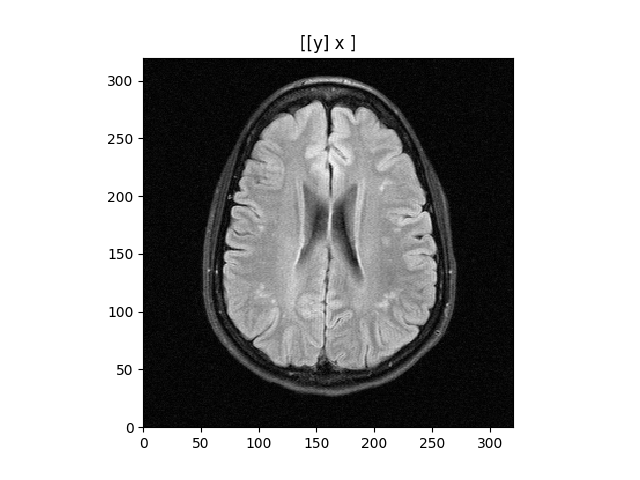

In [25]:
pl.ImagePlot(sp.ifft(ksp_scc[0,...], axes=(-1,-2)))

<IPython.core.display.Javascript object>


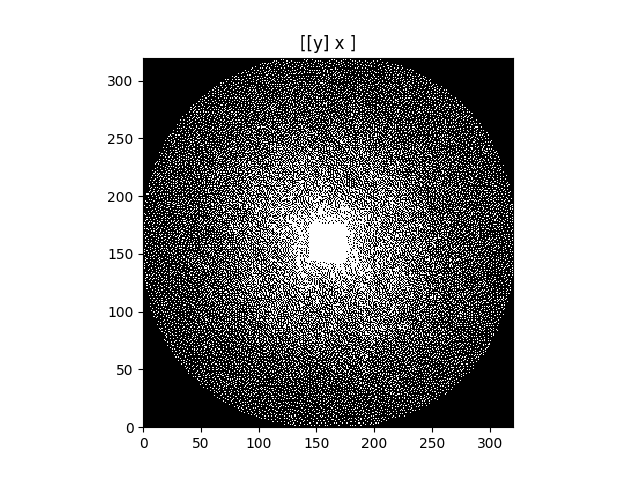

(320, 320)


In [26]:
pl.ImagePlot(mask)
print(mask.shape)

### Run Dictionary learning MRI reconstruction
We choose parameters that are similar to the image-based dictionary learning example from above. 

In [27]:
num_filters = 141
batch_size = 500
block_shape = [8, 8]
block_strides = [4, 4]
num_nonzero_coeffs = 15
max_iter = 20
nu = .1

use_multichannel = False

if use_multichannel:
    _ksp = mask[None,...] * ksp
    _maps = maps
    img_ref = img
else:
    _ksp = mask * ksp_scc[0,...]
    img_ref = sp.ifft(ksp_scc[0,...], axes=(-1,-2))
    _maps = None

device = sp.cpu_device
print(_ksp.shape)
with device:
    app = DictionaryLearningMRI(_ksp,
                          mask,
                          _maps,  
                          num_filters,
                          batch_size,
                          block_shape,
                          block_strides,
                          num_nonzero_coeffs,
                          nu=nu,
                          A_mode = 'omp',
                          D_mode = 'ksvd',
                          D_init_mode='data',
                          DC=True,
                          max_inner_iter=20,
                          max_iter=max_iter,
                          img_ref=img_ref,
                          device=device)
    out = app.run()

(320, 320)
num_data: 6241
num_points: 64


<IPython.core.display.Javascript object>


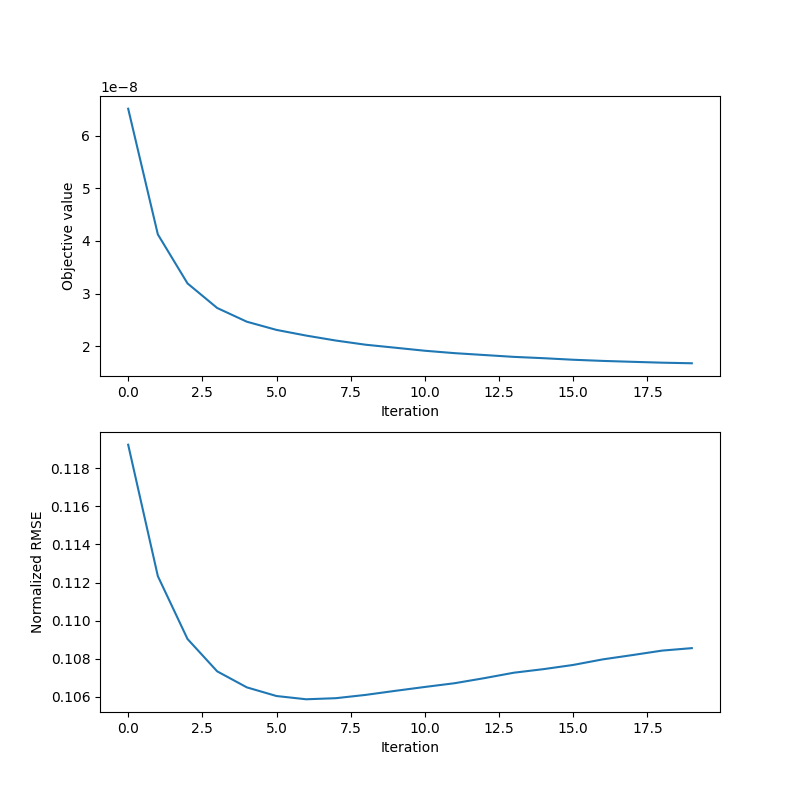

Text(0.5, 0, 'Iteration')

In [28]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(app.residuals)
plt.ylabel('Objective value')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.plot(app.nrmse_vals)
plt.ylabel('Normalized RMSE')
plt.xlabel('Iteration')

Visualize the dictionary as complex-valued patches. Use the arrow keys, "z", "m", "p", "r", "i", to interact with the figure. Use "h" to show help.
Notice the first atom is DC

(64, 141) (141, 6241)
[79, 79, 8, 8]
(8, 8, 141) (141, 79, 79)


/Users/jon/projects/dictionary_learning_ismrm_2020/src/sigpy/sigpy/plot.py:90: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self.fig = plt.figure()


<IPython.core.display.Javascript object>


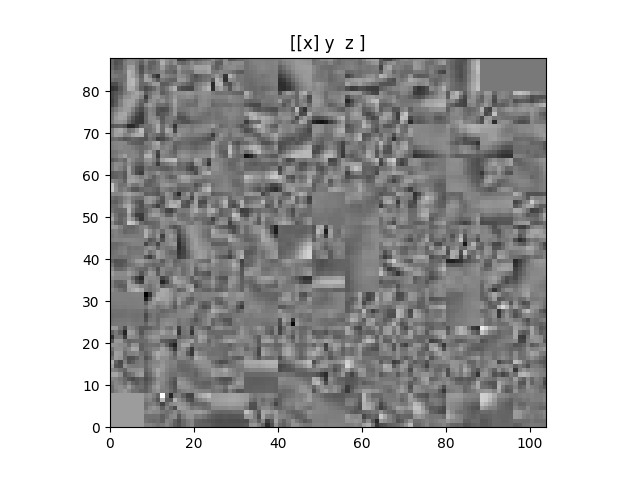

In [29]:
D_hat_flat, A_hat_flat = sp.to_device(out[0], sp.cpu_device), sp.to_device(out[1], sp.cpu_device)
print(D_hat_flat.shape, A_hat_flat.shape)
print(app.img_blocks_shape)
D_hat = D_hat_flat.reshape((*block_shape, num_filters))
A_hat = A_hat_flat.reshape((num_filters, *app.img_blocks_shape[:2]))

print(D_hat.shape, A_hat.shape)

pl.ImagePlot(D_hat, x=-3, y=-2, z=-1, interpolation='nearest', mode='r')

Visualize some of the sparse coefficients. By construction, every patch will include a sparse coefficient weighting on the first atom (since it is the DC atom). Patches with similar image content will activate similar coefficients.

<IPython.core.display.Javascript object>


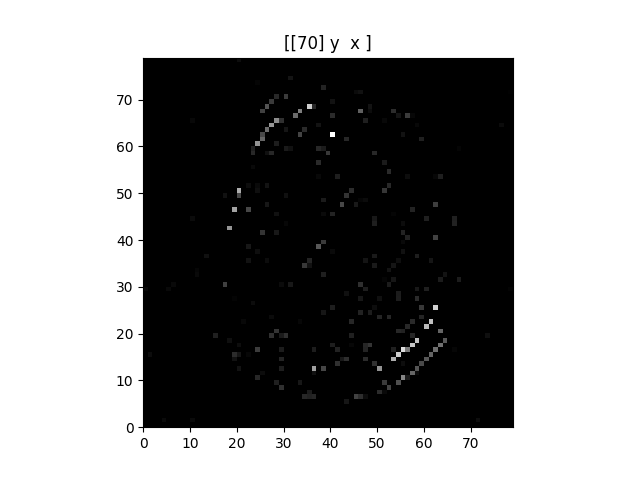

In [30]:
pl.ImagePlot(A_hat)

Compare the image output $\mathbf x$, the dictionary-approximation output $\mathbf R(\mathbf{DA})$, and a linear reconstruction $\mathbf E^\dagger \mathbf y$

In [31]:
img_hat_flat = D_hat_flat.dot(A_hat_flat)
img_dict = app.reshape_block_op * img_hat_flat.T
img_dict /= app.block_scale_factor
img_out = app.img_out

with device:
    img_linear = sp.app.LinearLeastSquares(app.mri_op,
                                           _ksp,
                                           lamda=.01,
                                          max_iter=30).run()




<IPython.core.display.Javascript object>


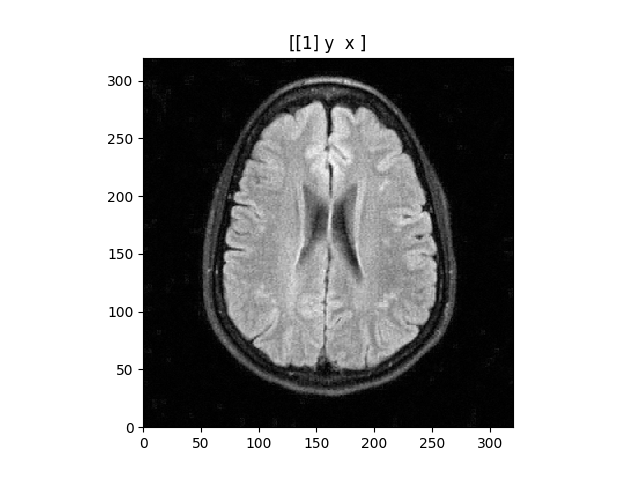

In [32]:
img_ref = sp.ifft(ksp_scc[0,...], axes=(-1,-2))

pl.ImagePlot(np.stack((img_ref, img_out, img_dict, img_linear)))

Compare error

<IPython.core.display.Javascript object>


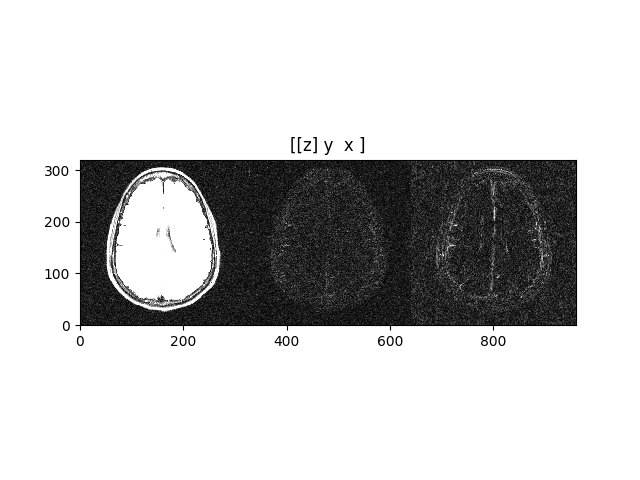

In [33]:
pl.ImagePlot(np.stack((img_ref, img_ref-img_out, img_ref-img_linear)))

I hope you enjoyed this tutorial!

- Jon Tamir  
[jtsense.com](http://jtsense.com)